In [1]:
from matplotlib.patches import Polygon

import numpy as np
from io import StringIO
import requests,json,os

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

typeface='Helvetica Neue'
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22

base_path='/Users/evogytis/Documents/manuscripts/skeeters/data/'
meta_path=os.path.join(base_path,'metadata/CMS001_CMS002_MergedAnnotations.csv')

metadata={}

for line in open(meta_path,'r'):
    l=line.strip('\r\n').split(',')
    if 'NewIDseqName' in l[0]:
        header=l
    else:
        metadata[l[0]]={header[i]:l[i].strip(' ') for i in range(len(l))}


genera_values={}
species_values={}
loc_points={}
sample_stats={}

for sample in metadata:
    loc=metadata[sample]['collected_by']
    genus=metadata[sample]['ska_genus']
    species=metadata[sample]['ska_species']
    
    sp='%s %s'%(genus,species)
    sample_stats[sample]={'loc':loc,'genus': genus, 'species': species}
    
    if genus!='' and metadata[sample]['collection_lat']!='NA':
        lat,lon=float(metadata[sample]['collection_lat']),float(metadata[sample]['collection_long'])

        if loc not in genera_values:
            genera_values[loc]={}
            species_values[loc]={}
            loc_points[loc]=(lon,lat)

        if genus not in genera_values[loc]:
            genera_values[loc][genus]=0
        if sp not in species_values[loc]:
            species_values[loc][sp]=0
            
        genera_values[loc][genus]+=1
        species_values[loc][sp]+=1

genera=set(sum([list(k.keys()) for k in genera_values.values()],[]))
loc_points['PLACER']=loc_points['PLCR']


California_counties_url='https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/california-counties.geojson'
response=requests.get(California_counties_url)

json_map=json.load(StringIO(response.text)) ## import json

features=json_map['features']
location_points={} ## location points will be stored here
polygons={} ## polygons will be stored here

locName='name' ## key name for each feature

for loc in features: ## iterate through features (locations)
    poly = np.asarray(loc['geometry']['coordinates']) ## get coordinates
    location=loc['properties'][locName]
    polygons[location]=[]
    location_points[location]=[]
    if loc['geometry']['type']=='MultiPolygon': ## multiple parts detected
        for part in np.asarray(poly): ## iterate over each component polygon
            for coords in np.asarray(part): ## iterate over coordinates
                coords=np.array(coords)
                xs=coords[:,0] ## longitudes
                ys=coords[:,1] ## latitudes

                location_points[location].append(np.vstack(zip(xs,ys))) ## append coordinates to location's list of coordinates
    if loc['geometry']['type']=='Polygon': ## location is single part
        for coords in np.asarray(poly): ## iterate over coordinates
            coords=np.array(coords)
            xs=coords[:,0] ## longitudes
            ys=coords[:,1] ## latitudes
            location_points[location].append(np.vstack(zip(xs,ys))) ## append coordinates to location's list of coordinates

    complete_location=[]
    for part in location_points[location]: ## iterate over each component of a location
        complete_location.append(Polygon(part,True)) ## create a polygon for each component of a location

    polygons[location]=complete_location ## assign list of polygons to a location

    
sample_colour={'ALCO':(0.49803923567136127, 0.43267975250879925, 0.52287583549817396), ## purple
               'WVAL':(0.88366013765335083, 0.77908497055371606, 0.18562091886997223), ## yellow
               'COAV':(0.8162552973803352, 0.41062668737243202, 0.29078047883276847), ## red
               'PLACER':(0.28098424626331703, 0.63955403192370541, 0.39507882933990629), ## green
               'PLCR':(0.28098424626331703, 0.63955403192370541, 0.39507882933990629), ## green
               'SAND':(0.4666666666666667, 0.7450980392156863, 0.8588235294117647), ## light blue
               'NA':  '#C0C0C0'}

rename={'PLCR':'Placerville', 
        'ALCO': 'Alameda\nCounty', 
        'WVAL': 'West \nValley', 
        'COAV': 'Coachella\nValley', 
        'SAND': 'San Diego'}

print(loc_points)

{'ALCO': (-122.07938, 37.55697), 'SAND': (-116.9594824, 32.7962659), 'WVAL': (-117.693828, 33.954615), 'COAV': (-116.082468, 33.516797), 'PLCR': (-121.305636, 38.739939), 'PLACER': (-121.305636, 38.739939)}


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:87: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:93: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


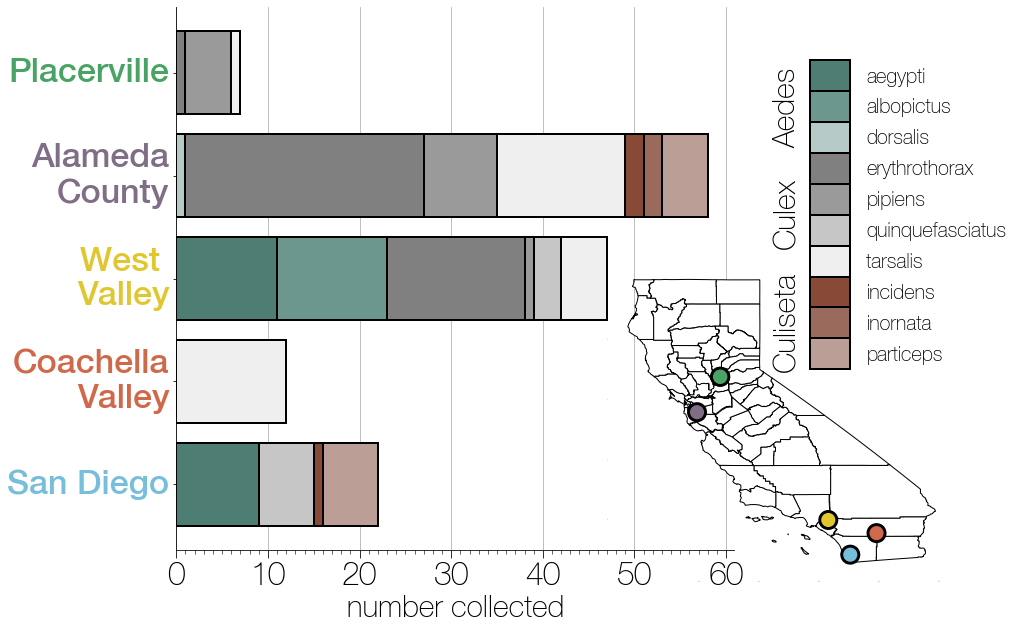

In [2]:
fig = plt.figure(figsize=(10, 10),facecolor='w')
gs = gridspec.GridSpec(1,1,wspace=0)

ax=plt.subplot(gs[0],facecolor='w')

subax=fig.add_axes([0.73, 0.07, 0.47, 0.47], frame_on=False)
subax.set_aspect(1)

genera_colours={'Culex': '#8F989C', 'Aedes': 'w', 'Culiseta':'#885F51'}
species_colours={'Culiseta particeps': '#BB9E95', 'Culiseta inornata': '#9A6B5C', 'Culiseta incidens': '#884936', 
                 'Aedes aegypti': '#4D7D73', 'Aedes albopictus': '#6C978E', 'Aedes dorsalis': '#B5CAC6', 
                 'Culex erythrothorax': '#808080', 'Culex pipiens': '#9A9A9A', 'Culex quinquefasciatus': '#C6C6C6', 'Culex tarsalis': '#EFEFEF'}

loc_labels=sorted(genera_values,key=lambda k: loc_points[k][1])

species_by_genera={g: set(sum([[w for w in k if w.split(' ')[0]==g] for k in species_values.values()],[])) for g in genera_colours}
species_to_genus={k.split(' ')[1]: k.split(' ')[0] for k in sum(map(list,species_values.values()),[])}

hatches=['','/','\\','x']
species_hatches={g: {sp: hatches[s] for s,sp in enumerate(sorted(species_by_genera[g]))} for g in genera_colours}

for i,loc in enumerate(loc_labels):
    gens=sorted(genera_values[loc])
    spp=sorted(species_values[loc])
    
#     for j in range(len(gens)):
#         value=genera_values[loc][gens[j]]
#         bottom=sum([genera_values[loc][genus] for genus in gens[:j]])
        
#         labels=ax.get_legend_handles_labels()[1]
#         label=gens[j] if gens[j] not in labels else ''
#         ax.barh(i,value,left=bottom,facecolor=genera_colours[gens[j]],
#                 edgecolor='w',lw=2,label=label,zorder=100)
    
    for j in range(len(spp)):
        value=species_values[loc][spp[j]]
#         h=species_hatches[spp[j].split(' ')[0]][spp[j]]
        h=''
        genus=spp[j].split(' ')[0]
        bottom=sum([species_values[loc][genus] for genus in spp[:j]])
        
        fc=genera_colours[genus]
        fc=species_colours[spp[j]]
        
        labels=ax.get_legend_handles_labels()[1]
        label=spp[j].split(' ')[1] if spp[j].split(' ')[1] not in labels else ''
        ax.barh(i,value,left=bottom,facecolor=fc,hatch=h,
                edgecolor='k',lw=2,label=label,zorder=100)

        
ax.set_yticks(range(len(loc_labels)))
ax.set_yticklabels(loc_labels,size=34,weight=500)

ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))

for loc in ax.get_yticklabels():
    loc.set_color(sample_colour[loc.get_text()])
ax.set_yticklabels([rename[x] for x in loc_labels],size=34,weight=500,va='center',ha='right')


boxes,labels=ax.get_legend_handles_labels()
boxes,labels=zip(*sorted(zip(boxes,labels),key=lambda k: (species_to_genus[k[1]],k[1])))
ax.legend(boxes,labels,loc=4,ncol=1,bbox_to_anchor=(1.52,0.3),fontsize=20,handlelength=2,handleheight=2,labelspacing=0.0,frameon=False)

ax.text(1.12,0.42,'Culiseta',size=30,rotation=90,ha='right',va='center',transform=ax.transAxes)
ax.text(1.12,0.62,'Culex',size=30,rotation=90,ha='right',va='center',transform=ax.transAxes)
ax.text(1.12,0.815,'Aedes',size=30,rotation=90,ha='right',va='center',transform=ax.transAxes)

[ax.spines[side].set_visible(False) for side in ax.spines if side not in ['bottom','left']]
ax.grid(axis='x')
ax.set_xlabel('number collected',size=30)
ax.tick_params(axis='x',which='major',size=8,labelsize=32)
ax.tick_params(axis='x',which='minor',size=4,labelsize=0)

subax.tick_params(size=0,labelsize=0)
[subax.spines[side].set_visible(False) for side in subax.spines]

for loc in sample_colour:
    if loc!='NA':
        subax.scatter(*loc_points[loc],s=200,facecolor=sample_colour[loc],edgecolor='none',zorder=10)
        subax.scatter(*loc_points[loc],s=400,facecolor='k',edgecolor='none',zorder=9)

for loc in polygons:
    county=PatchCollection(polygons[loc],facecolor='w',edgecolor='k',zorder=0)
    subax.add_collection(county)
subax.plot()

plt.savefig('/Users/evogytis/Documents/manuscripts/skeeters/figures/fig1_demography.png',bbox_inches='tight',dpi=300)
plt.savefig('/Users/evogytis/Documents/manuscripts/skeeters/figures/fig1_demography.pdf',bbox_inches='tight',dpi=300)    
plt.show()

In [3]:
header=sorted(sum(map(list,species_by_genera.values()),[]))
print('location\t%s'%('\t'.join(header)))

for loc in loc_labels:
    print('%s\t%s'%(loc,'\t'.join([str(species_values[loc][sp]) if sp in species_values[loc] else '0' for sp in header])))

location	Aedes aegypti	Aedes albopictus	Aedes dorsalis	Culex erythrothorax	Culex pipiens	Culex quinquefasciatus	Culex tarsalis	Culiseta incidens	Culiseta inornata	Culiseta particeps
SAND	9	0	0	0	0	6	0	1	0	6
COAV	0	0	0	0	0	0	12	0	0	0
WVAL	11	12	0	15	1	3	5	0	0	0
ALCO	0	0	1	26	8	0	14	2	2	5
PLCR	0	0	0	1	5	0	1	0	0	0
